# Import Library

In [ ]:
import numpy as np 
import pandas as pd #untuk proses dataframe dan csv
import matplotlib.pyplot as plt #untuk plotting grafik
import seaborn as sns #untuk plotting grafik
from sklearn.ensemble import RandomForestClassifier #ML yang
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import Dataset dan Penggabungan DataFrame

In [ ]:
def concat_df(train_data, test_data):
  return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)
  #class penggabungan data

df_train = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_train.csv')
df_test = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Testing Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

# Penjelasan dari dataset


*   PassengerId adalah id pada row, maka tidak ada pengaruh terhadap target yang dicari
*   Survived adalah target yang akan diprediksi, nilai 0 = Not Survived dan nilai 1 = Survived
*   Pclass (Passenger Class) adalah kategori level sosial ekonomi penumpang dengan nilai (1, 2 atau 3):
> 1. = Upper Class
> 2.   = Middle Class
> 3.   = Lower Class
*   Name, Sex dan Age merupakan data self-explanatory
*   SibSp adalah jumlah saudara dari penumpang
*   Parch adalah jumlah Orang Tua dan anak dari penumpang
*   Ticket adalah jumlah tiket penumpang
*   Fare adalah tarif yang di kenakan kepada penumpang
*   Cabin adalah nomor kabin penumpang
*   Embarked adalah pelabuhan pemberangkatan ada 3 pelabuhan (C, Q atau S):
> *   C = Cherbourg
> *   S = Southampton
> *   Q = Queenstown

# Exploring Data

In [ ]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Testing Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train Dataframe Columns: {}'.format(df_train.columns))
print('Test Dataframe Columns: {}'.format(df_test.columns))

Number of Training Examples = 891
Number of Testing Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Train Dataframe Columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Test Dataframe Columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# Mengetahui Korelasi Fitur

In [ ]:
df_train_corr = df_train.corr().abs()
print(df_train_corr.to_string())

             PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000  0.005007  0.035144  0.036847  0.057527  0.001652  0.012658
Survived        0.005007  1.000000  0.338481  0.077221  0.035322  0.081629  0.257307
Pclass          0.035144  0.338481  1.000000  0.369226  0.083081  0.018443  0.549500
Age             0.036847  0.077221  0.369226  1.000000  0.308247  0.189119  0.096067
SibSp           0.057527  0.035322  0.083081  0.308247  1.000000  0.414838  0.159651
Parch           0.001652  0.081629  0.018443  0.189119  0.414838  1.000000  0.216225
Fare            0.012658  0.257307  0.549500  0.096067  0.159651  0.216225  1.000000


Pada data ini dapat dilihat bahwa target variable kita Survived sangat besar korelasinya dengan Pclass dan Fare. Sedangkan Age sangat berkaitan dengan Pclass, Sibling Spouse (SibSp), Parent Children (Parch).

Dapat diasumsikan bahwa kebanyakan orang yang selamat adalah orang dengan PClass atas dan Tuanya umur seseorang dapat dikatakan dia akan membawa saudara/orang tua/anak/pasangan.

Dan Fare (harga) tentu saja berkaitan dengan Pclass (kelas penumpang) seorang penumpang.

# Mengidentifikasi banyak missing data dari kolom

In [ ]:
def display_missing(df):
  for col in df.columns.tolist(): #pengulangan pada setiap kolom yang ada pada data
    print('{} column missing values: {}'.format(col, df[col].isnull().sum())) #mencari banyak kolom kosong
  print('\n')

for df in dfs: #pengulangan untuk kedua dataset yang tersimpan di variabel dfs
  print('{}'.format(df.name))
  display_missing(df) #menjalankan class di atas

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Testing Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




# Mencari nilai untuk missing value
pada kasus ini yaitu kolom usia/Age yang digroupby dengan kolom Pclass dan Sex

In [ ]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age'] #mencari nilai median dari usia yang disesuaikan dengan kolom Pclass dan Sex
print('{}\n'.format(age_by_pclass_sex))

for pclass in range (1,4): #pengulangan 3 kali untuk setiap pclass
  for sex in ['female', 'male']: #pengulangan 2 kali untuk setiap sex
    print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0


# Mengisi nilai kosong pada kolom Embarked, Age dan Fare

In [ ]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x:x.fillna(x.median()))
#mengisi setiap nilai kosong kolom usia dengan nilai tengahnya yang telah di groupby sesuai pclass dan sex 

df_all['Embarked'] = df_all['Embarked'].fillna('S') #nilai kosong pada embarked diisi dengan S atau keberangkatan dari Southampton

med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

*   Untuk Embarked atau kota keberangkatan dikarenakan mayoritas penumpang berangkat dari Southhampton oleh karena itu data yang kosong diisi dengan S
*   Untuk Fare atau jumlah harga tiket dikarenakan berkaitan dengan Kelas Penumpang (Pclass), Jumlah anggota keluarga inti (Parch), dan Jumlah saudara (SibSp) 
> maka diisi dengan nilai median dengan penumpang yang memiliki Pclass paling rendah yaitu dengan nilai 3, tidak memiliki keluarga ataupun saudara dengan nilai 0 pada Parch dan SibSp









# Exploring data

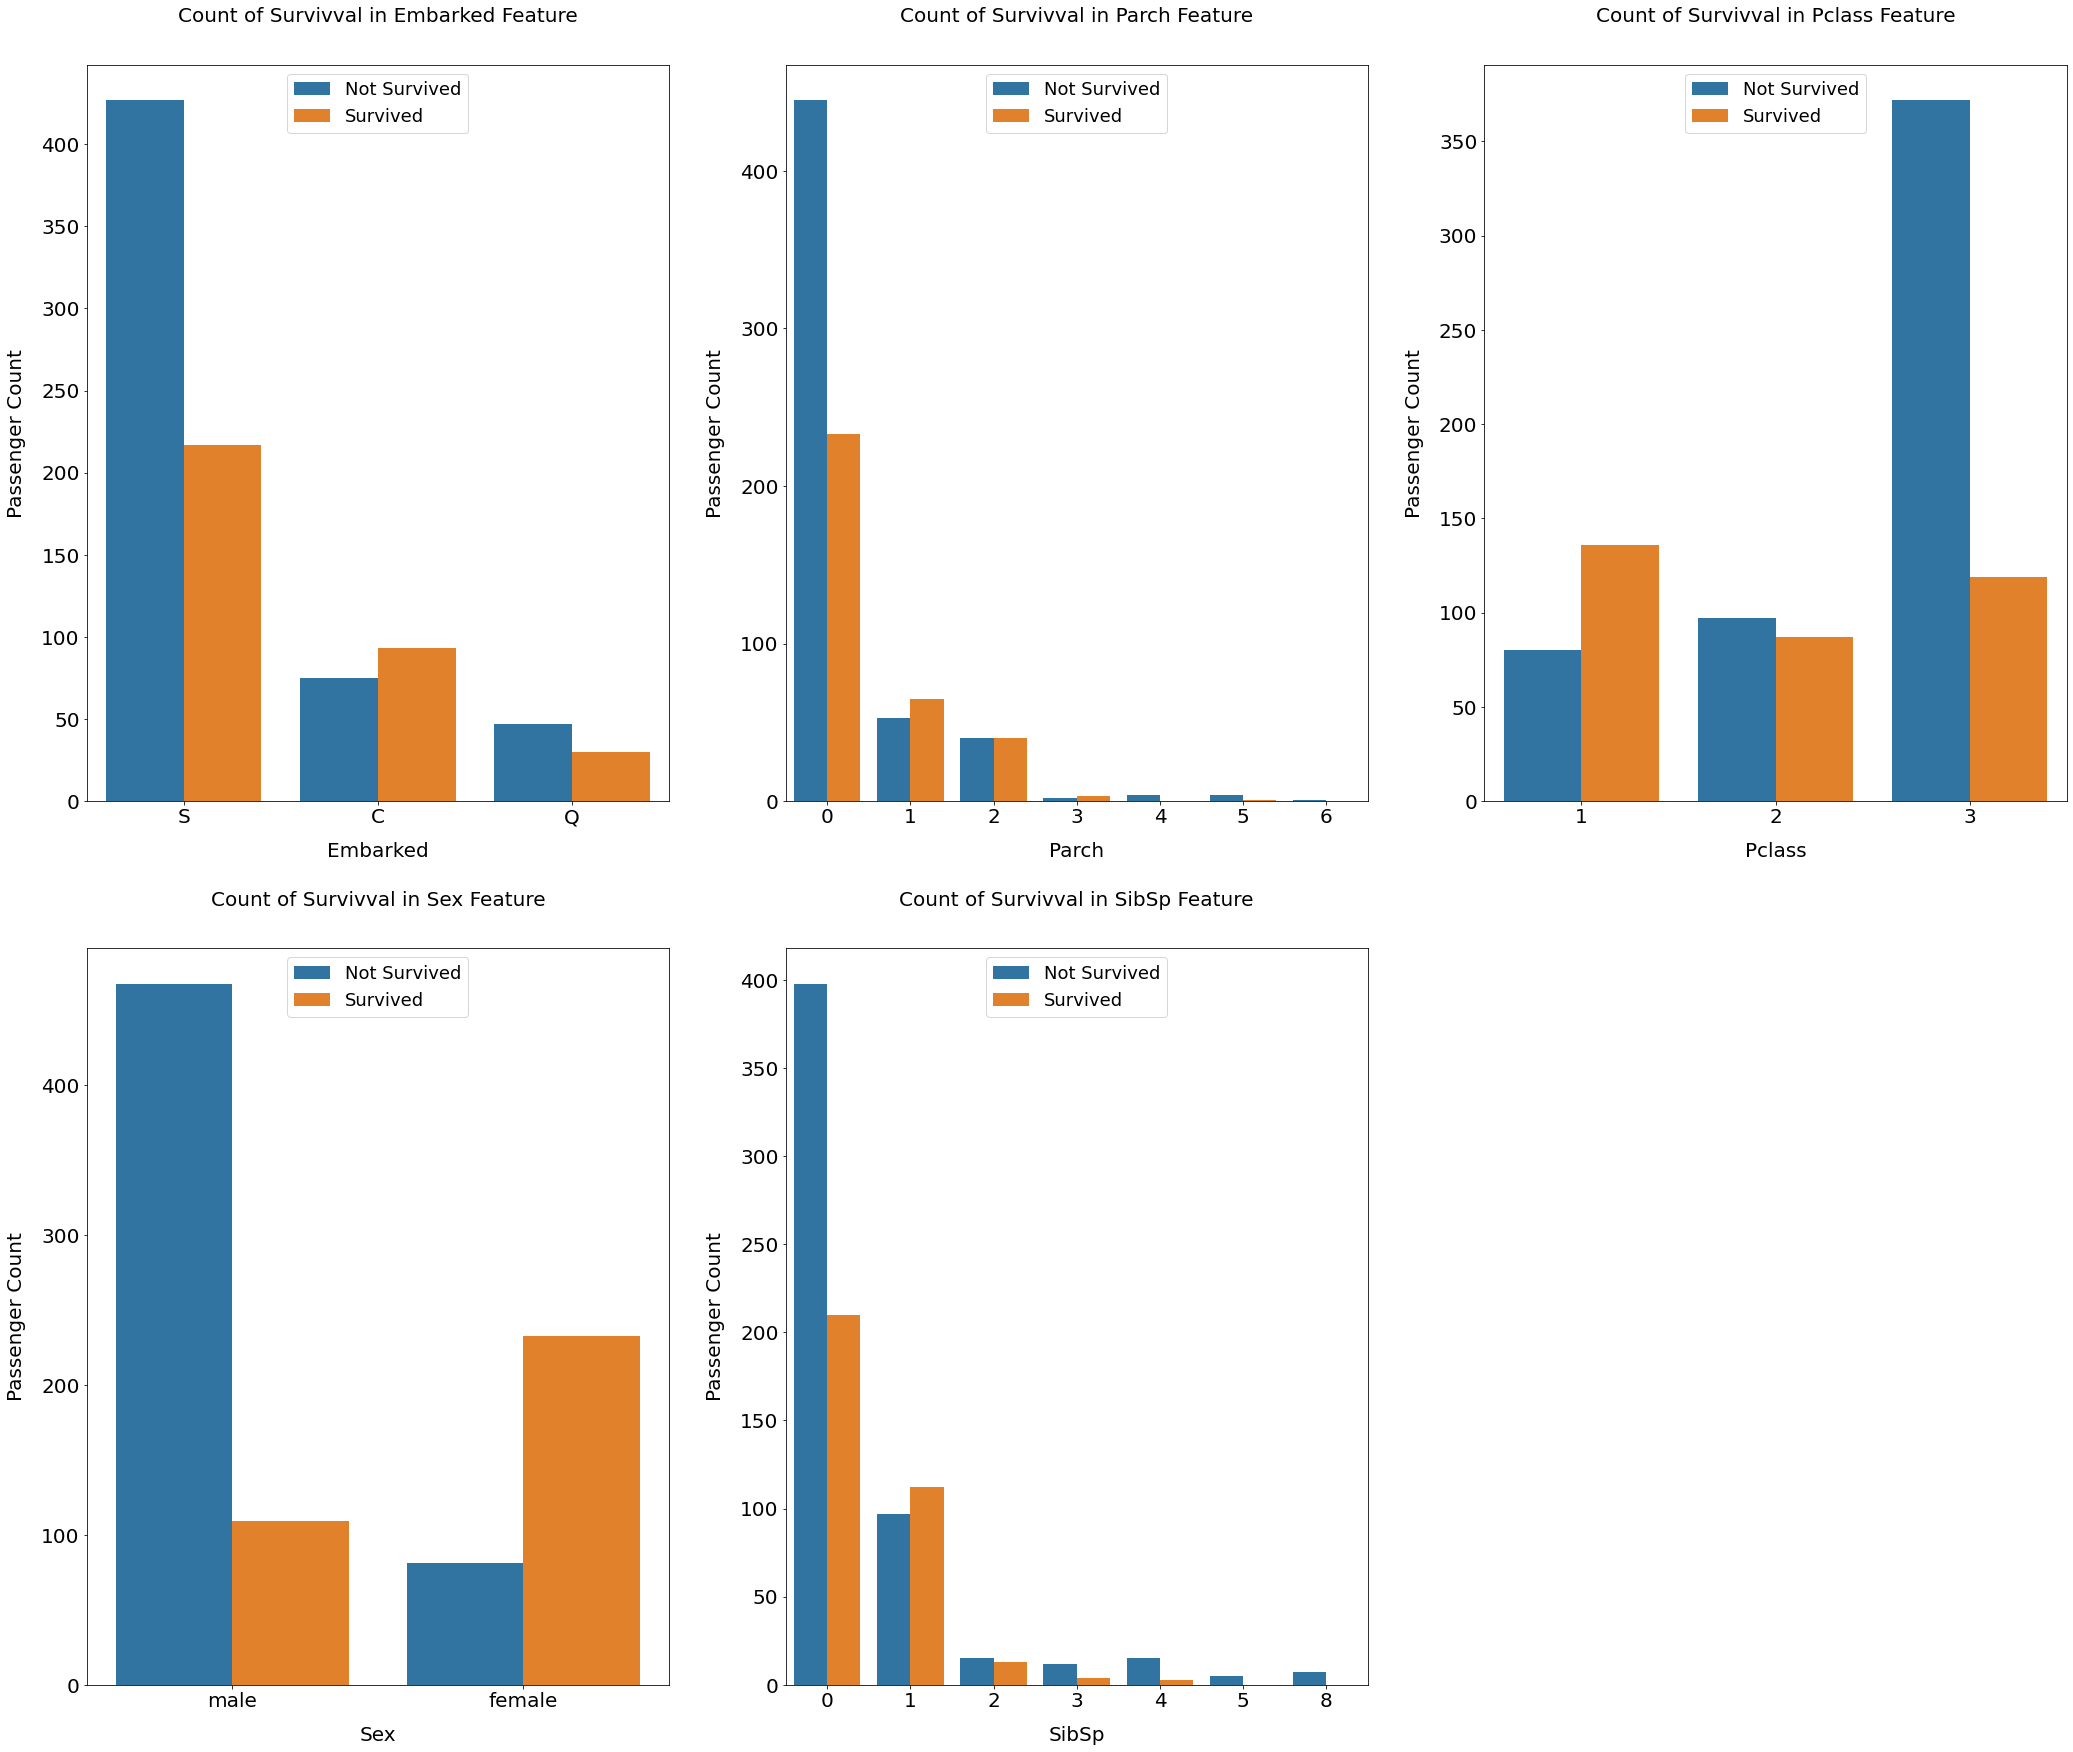

In [ ]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features,1): #enumerate berguna menambahkan penghitung (indeks) ke objek iterable dan mengembalikannya
  plt.subplot(2,3,i)
  sns.countplot(x=feature, hue='Survived', data=df_train)

  plt.xlabel('{}'.format(feature), size=20, labelpad=15)
  plt.ylabel('Passenger Count', size=20, labelpad=15)
  plt.tick_params(axis='x', labelsize=20)
  plt.tick_params(axis='y', labelsize=20)

  plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size':18})
  plt.title('Count of Survivval in {} Feature'.format(feature), size=20, y=1.05) 

Dapat dilihat dari plot yang dihasilkan bahwa:
*   penumpang yang berangkat dari Cherbourg lebih banyak selamat dibandingkan dengan penumpang dari Southampton dimana hanya setengahnya yg selamat
*   penumpang yang membawa anggota keluarga inti sebanyak 1 lebih banyak yang selamat dibandingkan yang lainnya
*   penumpang dengan kelas penumpang 1 memiliki kemungkinan selamat lebih tinggi dibandingkan dengan penumpang kelas 3 dimana hanya sedikit yang selamat
*   penumpang perempuan juga lebih banyak selamat dibandingkan penumpang laki-laki dikarenakan oleh prioritas penyelamatan
*   penumpang yang membawa 1 sodara berkemungkinan selamat jauh lebih besar dibandingkan dengan yang membawa 2 sodara dengan kemungkinan selamat yang cukup kecil








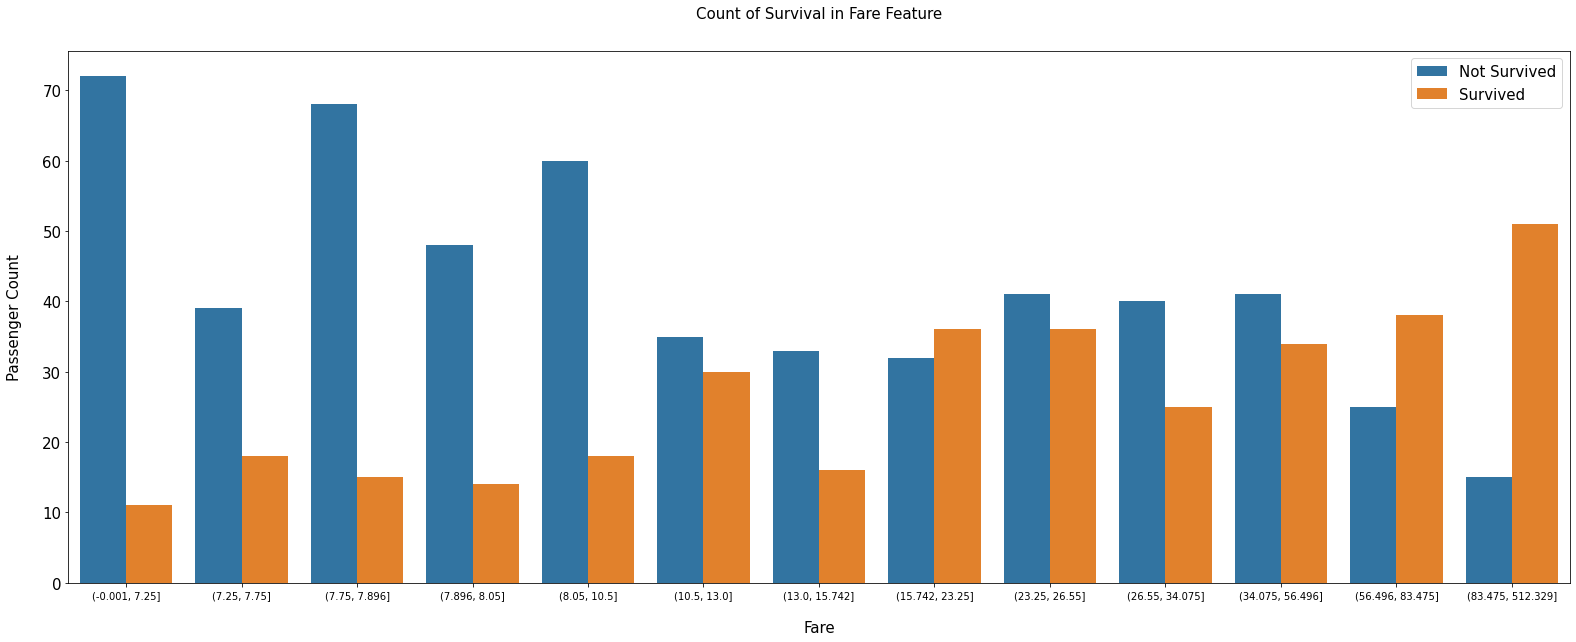

In [ ]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13) #qcut digunakan untuk membagi menjadi 13 kelompok data secara kuartil dan seimbang seusai sampel

fig, axs = plt.subplots(figsize=(22,9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size':15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)
plt.tight_layout()
plt.show()

Berdasarkan plot yang dihasilkan di atas
*   Semakin mahal harga tiket, maka kemungkinan penumpang selamat lebih tinggi dapat dilihat dengan harga tiket yang dimulai dari 56 ke atas
*   penumpang yang selamat dimulai dengan harga tiket 10.5 sudah meningkat, keculai pada penumpang yang memegang tiket berharga 13-15.742



# Feature Engineering

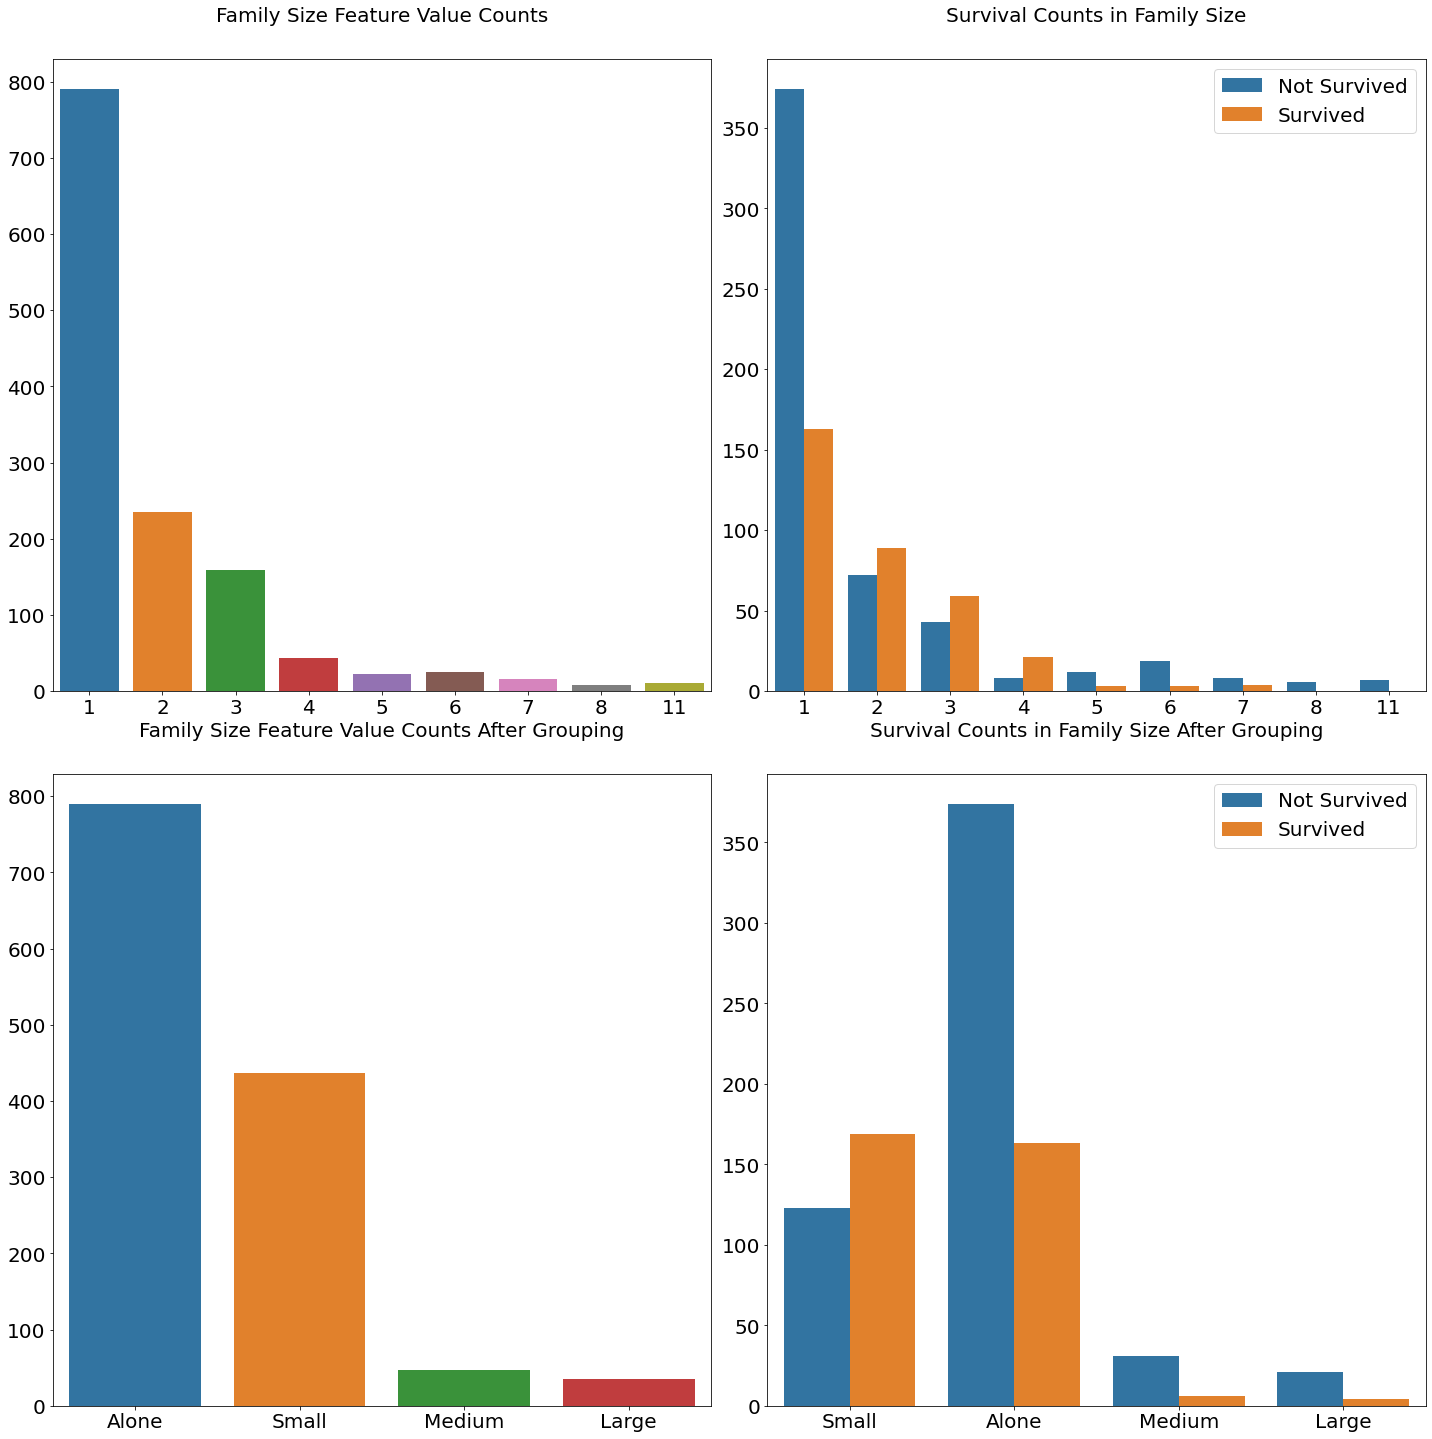

In [ ]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20,20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size', size=20, y=1.05)

family_map = {1:'Alone', 2:'Small', 3:'Small', 4:'Small', 5:'Medium', 6:'Medium', 7:'Large', 8:'Large', 11:'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x = df_all['Family_Size_Grouped'].value_counts().index, y = df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
  axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size':20})
  for j in range(2):
    axs[i][j].tick_params(axis='x', labelsize=20)
    axs[i][j].tick_params(axis='y', labelsize=20)
    axs[i][j].set_xlabel('')
    axs[i][j].set_ylabel('')
plt.tight_layout()
plt.show()


*   Family_Size merupakan penggabungan 
dari Parch + SibSP + 1 termasuk penumpang itu sendiri
*   Family_Size_Grouped merupakan klasifikasi jumlah anggota keluarga sesuai dengan banyak anggota keluarga itu sendiri

> Melalui plot yang dihasilkan tampak bahwa penumpang dengan jumlah keluarga 2,3, dan 4 memiliki kemungkinan selamat yang lebih tinggi dibandingkan yang lainnya. Serta klasifikasi keluarga 'small' juga tampak memiliki tingkat keselamatan yang lebih tinggi dibandingkan klasifikasi yang lainnya





In [ ]:
duplicate = df_all['Ticket'][df_all['Ticket'].duplicated()]
print('{}\n--------------------------\n'.format(duplicate))
print(df_all['Age'].loc[df_all['Ticket']=='349909'])

24                  349909
71                 CA 2144
88                   19950
117                  11668
119                 347082
               ...        
1298                113503
1300    SOTON/O.Q. 3101315
1302                 19928
1305              PC 17758
1308                  2668
Name: Ticket, Length: 380, dtype: object
--------------------------

7        2.0
24       8.0
374      3.0
567     29.0
1280     6.0
Name: Age, dtype: float64


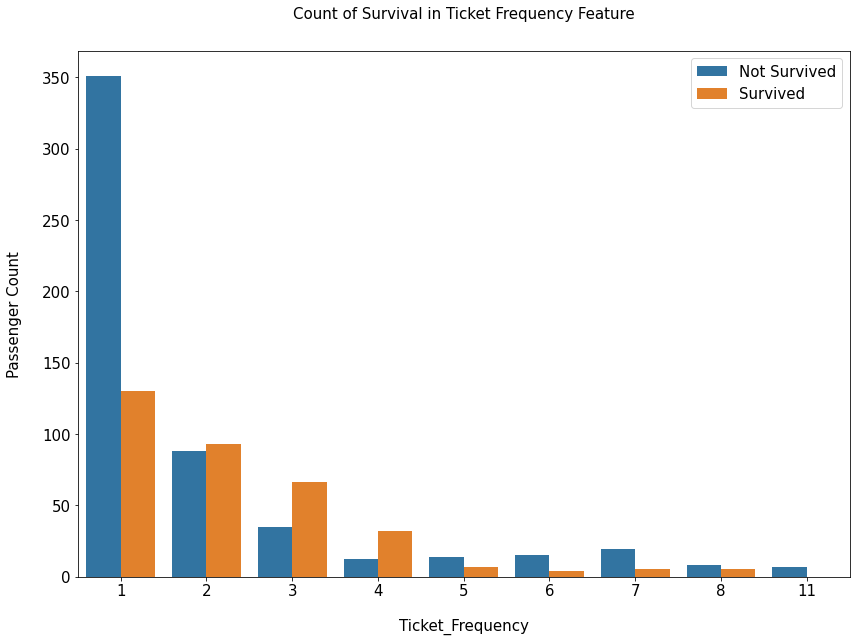

In [ ]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12,9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket_Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size':15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)
plt.tight_layout()
plt.show()


Ticket_Frequency merupakan penggabungan dari penumpang yang memiliki Ticket yang sama

> hasil dari plot tidak jauh berbeda dibandingkan plot pada Family_Size tapi feature ini berbeda dikarenakan terdapat teman yang menggunakan ticket yang sama tetapi tidak termasuk keluarga



In [ ]:
df_all['Title'] = df_all['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

print(df_all['Title'].unique())

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

print(df_all['Title'].unique())
print(df_all['Title'].value_counts())

[' Mr' ' Mrs' ' Miss' ' Master' ' Don' ' Rev' ' Dr' ' Mme' ' Ms' ' Major'
 ' Lady' ' Sir' ' Mlle' ' Col' ' Capt' ' the Countess' ' Jonkheer' ' Dona']
[' Mr' ' Mrs' ' Miss' ' Master' ' Don' ' Rev' ' Dr' ' Mme' ' Ms' ' Major'
 ' Lady' ' Sir' ' Mlle' ' Col' ' Capt' ' the Countess' ' Jonkheer' ' Dona']
 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Ms                2
 Mlle              2
 Major             2
 the Countess      1
 Dona              1
 Don               1
 Mme               1
 Lady              1
 Jonkheer          1
 Capt              1
 Sir               1
Name: Title, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Title mengambil jabatan seseorang yang diambil dari data nama. fitur ini berguna untuk mengklasifikasikan seseorang sudah menikah atau belum. Dari fitur title ini dapat dipastikan jika seseorang dengan jabatan 'Mrs' berarti dia sudah menikah

Text(0.5, 1.05, 'Title Feature Value Counts After Grouping')

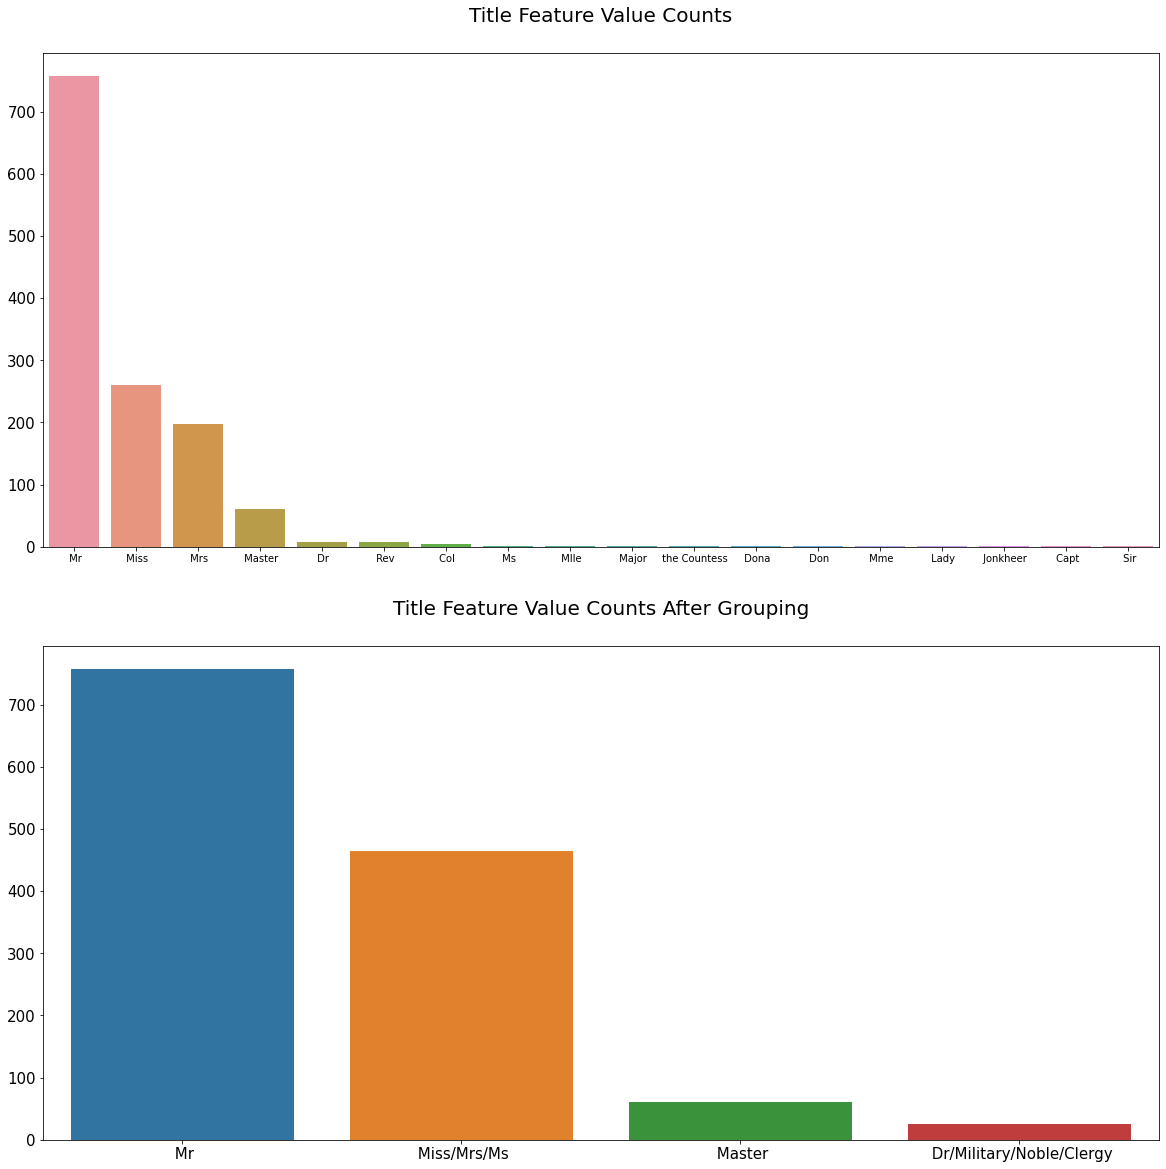

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20,20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
	axs[i].tick_params(axis='y', labelsize=15)
	
axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

pattern = '|'.join(['Mrs','Miss','Mme','Ms','Lady','Mlle','the Countess','Dona'])
df_all['Title'] = df_all['Title'].str.replace(pattern, 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer','Capt', 'Sir','Don', 'Rev'], 'Dr/Military/Noble/Clergy', regex=True)


sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

Fitur selanjutnya merupakan kelanjutan dari sebelumnya dimana *'Miss', 'Mrs', 'Ms', 'Mlle', 'Lady','Mme', 'the Countess', 'Dona'* dikelompokkan menjadi *'Miss/Mrs/Ms'* dan *'Dr', 'Col', 'Major', 'Jonkheer','Capt', 'Sir','Don', 'Rev'*] dikelompokkan menjadi *'Dr/Military/Noble/Clergy'*

In [ ]:
print(df_all.head())

    Age Cabin Embarked  ... Ticket_Frequency         Title  Is_Married
0  22.0   NaN        S  ...                1            Mr           0
1  38.0   C85        C  ...                2   Miss/Mrs/Ms           0
2  26.0   NaN        S  ...                1   Miss/Mrs/Ms           0
3  35.0  C123        S  ...                2   Miss/Mrs/Ms           0
4  35.0   NaN        S  ...                1            Mr           0

[5 rows x 17 columns]


# Modelling

>untuk meilhat apakah dataset yang telah dilakukan featuring akan meningkatkan akurasi dibandingkan dengan dataset murni



In [ ]:
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs= [df_train, df_test]

non_numeric_features = ['Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs: #melakukan encoding pada data non numerical menjadi data kategorikal [0-n]
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features= []

for df in dfs: 
#melakukan encoder untuk mengubah feature kategori menjadi one hot 
#dimana akan menghasilkan beberapa kolom tergantung banyaknya kategori
#contohnya Pclass yang terdiri dari 3, akan menjadi Pclass_1 s/d 3, dan valuenya menjadi [0-1]
  for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'. format(feature, n ) for n in range(1, n+1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:5]], axis=1)
df_test = pd.concat ([df_test, *encoded_features[5:]], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived', 'Name', 'PassengerId', 'Pclass','Sex', 'Ticket', 'Title']

df_all.drop(columns=drop_cols, inplace=True)

print(df_all.head())

   Age  Embarked_1  Embarked_2  Embarked_3  ...  Title_1  Title_2  Title_3  Title_4
0   28         0.0         0.0         1.0  ...      0.0      0.0      0.0      1.0
1   52         1.0         0.0         0.0  ...      0.0      0.0      1.0      0.0
2   34         0.0         0.0         1.0  ...      0.0      0.0      1.0      0.0
3   48         0.0         0.0         1.0  ...      0.0      0.0      1.0      0.0
4   48         0.0         0.0         1.0  ...      0.0      0.0      0.0      1.0

[5 rows x 22 columns]


In [ ]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 22)
y_train shape: (891,)
X_test shape: (418, 22)


# Modelling menggunakan Feature Engineering

In [ ]:
random_forest = RandomForestClassifier(
    criterion='gini',
    n_estimators = 1100,
    max_depth = 5,
    min_samples_split=4,
    min_samples_leaf=5,
    max_features='auto',
    oob_score=True,
    random_state=50)
random_forest.fit(X_train,y_train)#menjalankan model menggunakan X_train dan y_train


RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=1100, oob_score=True, random_state=50)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring="accuracy")
print("Scores", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores [0.83333333 0.86516854 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8327715355805243
Standard Deviation: 0.03604127069930158


# Modelling tanpa menggunakan feature engineering

In [ ]:
df_all = concat_df(df_train, df_test)

drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived', 'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title', 'Family_Size_Grouped_1', 'Family_Size_Grouped_2', 'Family_Size_Grouped_3', 'Family_Size_Grouped_4', 'Ticket_Frequency', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Is_Married']

df_all.drop(columns=drop_cols, inplace=True)

print(df_all.head())

X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

   Age  Embarked_1  Embarked_2  Embarked_3  ...  Pclass_3  Sex_1  Sex_2  SibSp
0   28         0.0         0.0         1.0  ...       1.0    0.0    1.0      1
1   52         1.0         0.0         0.0  ...       0.0    1.0    0.0      1
2   34         0.0         0.0         1.0  ...       1.0    1.0    0.0      0
3   48         0.0         0.0         1.0  ...       0.0    1.0    0.0      1
4   48         0.0         0.0         1.0  ...       1.0    0.0    1.0      0

[5 rows x 12 columns]
X_train shape: (891, 12)
y_train shape: (891,)
X_test shape: (418, 12)


In [ ]:
random_forest = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=50)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=1100, oob_score=True, random_state=50)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.84269663 0.76404494 0.87640449 0.85393258 0.80898876
 0.79775281 0.7752809  0.86516854 0.80898876]
Mean: 0.818214731585518
Standard Deviation: 0.03700330937285851


Dapat dilihat bahwa akurasi dengan menggunakan feature engineering adalah 83,28% sedangkan model tanpa menggunakan feature engineering memiliki akurasi sebesar 81,82%
> tampak terdapat 2% kenaikan setelah melakukan feature engineering
